# MRI Preprocessing Pipeline

Este notebook executa as principais etapas de pré-processamento em imagens de ressonância magnética (MRI) T1: normalização Z-score, correção de bias field (N4ITK), equalização de histograma e redução de ruído (filtro Gaussiano e difusão anisotrópica).

Inclui:
- Execução em lote para uma pasta de imagens
- Exemplo detalhado com visualização antes/depois para uma imagem específica


In [4]:
import os
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter
import SimpleITK as sitk
try:
    from medpy.filter.smoothing import anisotropic_diffusion
    medpy_available = True
except ImportError:
    medpy_available = False
    print('MedPy not installed: anisotropic diffusion will be skipped.')


## Funções de pré-processamento


In [17]:
def zscore_normalization(data):
    return (data - np.mean(data)) / np.std(data)

def n4_bias_correction_from_array(data, affine, out_path=None):
    import SimpleITK as sitk
    if data.ndim == 4 and data.shape[-1] == 1:
        data = np.squeeze(data, axis=-1)
    img = sitk.GetImageFromArray(data.astype(np.float32))
    img.SetSpacing((1.0, 1.0, 1.0))  # Adjust if you know the real spacing
    mask = sitk.OtsuThreshold(img, 0, 1, 200)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    img_corr = corrector.Execute(img, mask)
    if out_path:
        sitk.WriteImage(img_corr, str(out_path))
    return sitk.GetArrayFromImage(img_corr), img_corr

def histogram_equalization(data):
    data_min = np.min(data)
    data_max = np.max(data)
    data_norm = (data - data_min) / (data_max - data_min)
    data_eq = exposure.equalize_hist(data_norm)
    return data_eq * (data_max - data_min) + data_min

def gaussian_smoothing(data, sigma=1):
    return gaussian_filter(data, sigma=sigma)

def anisotropic_diffusion_filter(data, niter=10, kappa=50):
    if not medpy_available:
        raise ImportError('MedPy is not installed.')
    return anisotropic_diffusion(data, niter=niter, kappa=kappa)


## Exemplo detalhado: IBSR_10


In [18]:
example_path = Path('../data/subset/IBSR_10/images/analyze/IBSR_10_ana.img')
img = nib.load(str(example_path))
data = img.get_fdata()

# Z-score normalization
data_z = zscore_normalization(data)
# N4ITK bias correction
data_n4, img_n4 = n4_bias_correction_from_array(data, img.affine)
# Histogram equalization
data_eq = histogram_equalization(data)
# Gaussian smoothing
data_gauss = gaussian_smoothing(data)
# Anisotropic diffusion (if available)
if medpy_available:
    data_diff = anisotropic_diffusion_filter(data)
else:
    data_diff = None


### Visualização antes/depois (slice central)


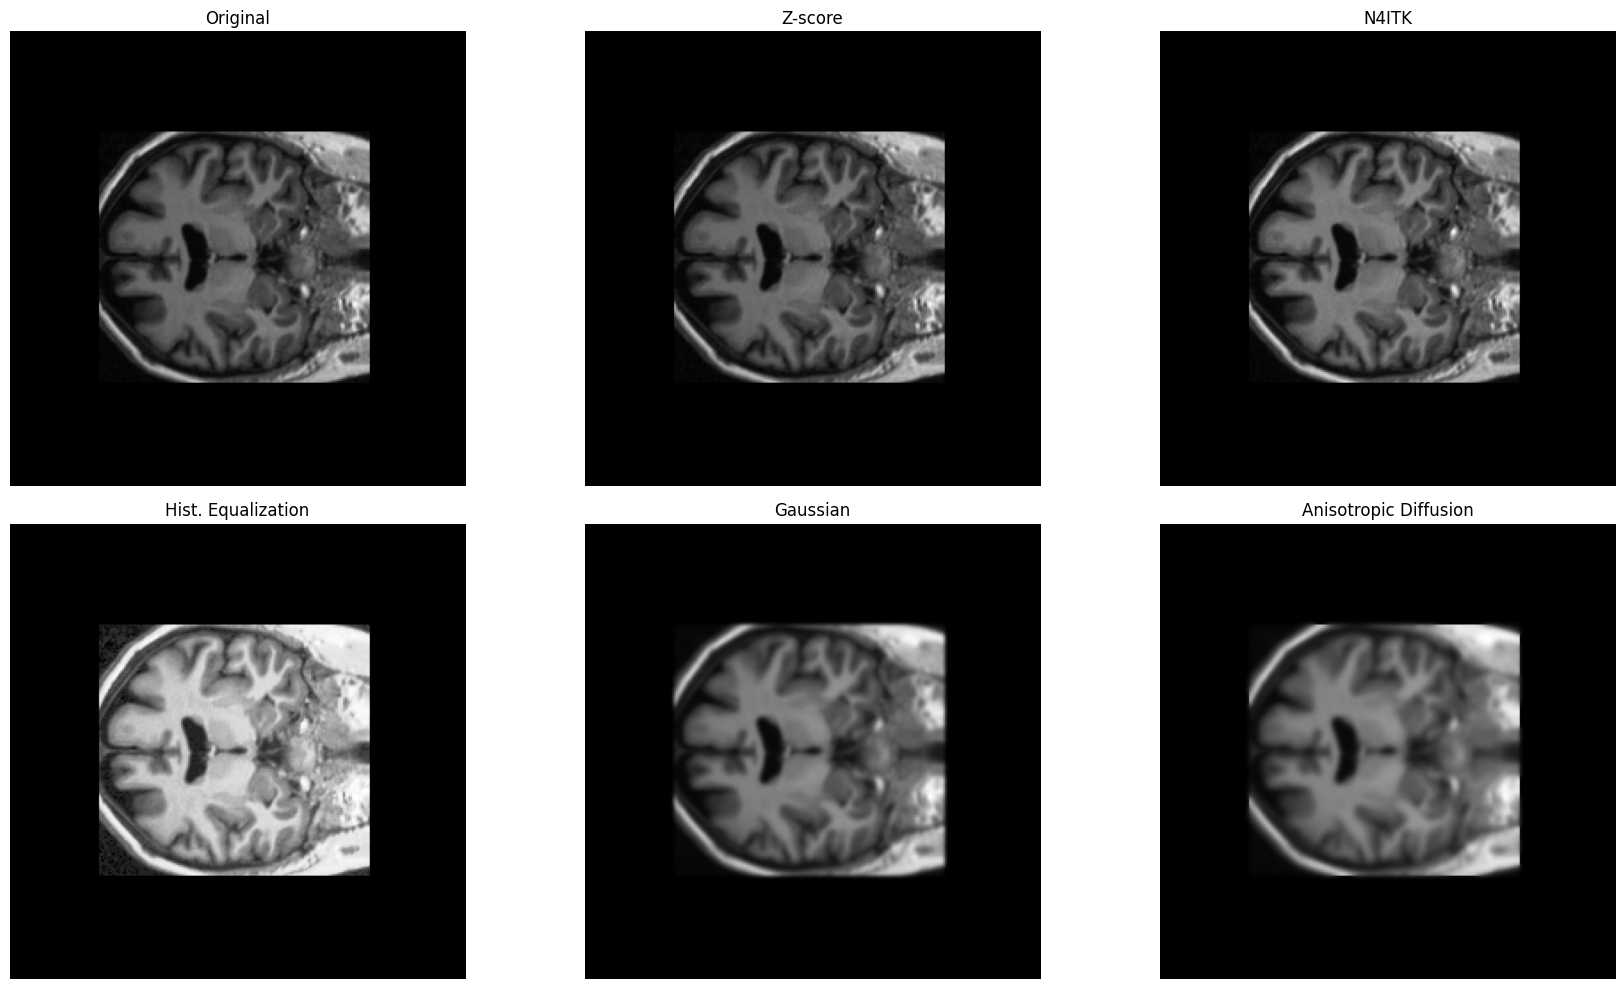

In [19]:
slice_idx = data.shape[2] // 2
plt.figure(figsize=(18,10))
plt.subplot(2,3,1); plt.imshow(data[:,:,slice_idx], cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(data_z[:,:,slice_idx], cmap='gray'); plt.title('Z-score'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(data_n4[:,:,slice_idx], cmap='gray'); plt.title('N4ITK'); plt.axis('off')
plt.subplot(2,3,4); plt.imshow(data_eq[:,:,slice_idx], cmap='gray'); plt.title('Hist. Equalization'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(data_gauss[:,:,slice_idx], cmap='gray'); plt.title('Gaussian'); plt.axis('off')
if data_diff is not None:
    plt.subplot(2,3,6); plt.imshow(data_diff[:,:,slice_idx], cmap='gray'); plt.title('Anisotropic Diffusion'); plt.axis('off')
plt.tight_layout()
plt.savefig("preprocessing.png", dpi=300, bbox_inches="tight")
plt.show()

## Execução em lote para uma pasta de imagens


In [20]:
input_dir = Path('../data/subset')
output_dir = Path('../data/preprocessed')
output_dir.mkdir(exist_ok=True)

for subject_dir in input_dir.glob('IBSR_*'):
    img_path = subject_dir / 'images/analyze' / f'{subject_dir.name}_ana.img'
    if not img_path.exists():
        continue
    img = nib.load(str(img_path))
    data = img.get_fdata()
    # Z-score
    data_z = zscore_normalization(data)
    nib.save(nib.Nifti1Image(data_z, img.affine), output_dir / f'{subject_dir.name}_zscore.nii.gz')
    # N4ITK
    data_n4, img_n4 = n4_bias_correction_from_array(data, img.affine)
    sitk.WriteImage(img_n4, str(output_dir / f'{subject_dir.name}_n4.nii.gz'))
    # Histogram equalization
    data_eq = histogram_equalization(data)
    nib.save(nib.Nifti1Image(data_eq, img.affine), output_dir / f'{subject_dir.name}_eq.nii.gz')
    # Gaussian
    data_gauss = gaussian_smoothing(data)
    nib.save(nib.Nifti1Image(data_gauss, img.affine), output_dir / f'{subject_dir.name}_gauss.nii.gz')
    # Anisotropic diffusion
    if medpy_available:
        data_diff = anisotropic_diffusion_filter(data)
        nib.save(nib.Nifti1Image(data_diff, img.affine), output_dir / f'{subject_dir.name}_diff.nii.gz')
    print(f'Preprocessing done for {subject_dir.name}')


Preprocessing done for IBSR_02
Preprocessing done for IBSR_04
Preprocessing done for IBSR_10
Preprocessing done for IBSR_03
